<a href="https://colab.research.google.com/github/HasibAlMuzdadid/Machine-Learning-and-Deep-Learning-Projects/blob/main/semantic%20segmentation%20for%20autonomous%20driving%5Bu-net%5D/semantic_segmentation_for_autonomous_driving%5Bu_net%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Semantic Image Segmentation [U-Net]**

We'll be building our own U-Net, a type of CNN designed for quick, precise image segmentation and using it to predict a label for every single pixel in an image.


This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?" but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows us to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown.



As we might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars or any number of traffic obstacles that can put peoples' lives in danger. 



In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import imageio
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

%matplotlib inline

In [ ]:
# load data
path = ''
image_path = os.path.join(path,'/content/drive/MyDrive/u net/data/CameraRGB/')
mask_path = os.path.join(path,'/content/drive/MyDrive/u net/data/CameraMask/')
image_list = list(sorted(os.listdir(image_path)))
mask_list = list(sorted(os.listdir(mask_path)))
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [ ]:
print(image_list)

['/content/drive/MyDrive/u net/data/CameraRGB/000026.png', '/content/drive/MyDrive/u net/data/CameraRGB/000027.png', '/content/drive/MyDrive/u net/data/CameraRGB/000028.png', '/content/drive/MyDrive/u net/data/CameraRGB/000029.png', '/content/drive/MyDrive/u net/data/CameraRGB/000032.png', '/content/drive/MyDrive/u net/data/CameraRGB/000033.png', '/content/drive/MyDrive/u net/data/CameraRGB/000034.png', '/content/drive/MyDrive/u net/data/CameraRGB/000043.png', '/content/drive/MyDrive/u net/data/CameraRGB/000044.png', '/content/drive/MyDrive/u net/data/CameraRGB/000045.png', '/content/drive/MyDrive/u net/data/CameraRGB/000073.png', '/content/drive/MyDrive/u net/data/CameraRGB/000084.png', '/content/drive/MyDrive/u net/data/CameraRGB/000085.png', '/content/drive/MyDrive/u net/data/CameraRGB/000156.png', '/content/drive/MyDrive/u net/data/CameraRGB/000688.png', '/content/drive/MyDrive/u net/data/CameraRGB/000689.png', '/content/drive/MyDrive/u net/data/CameraRGB/000690.png', '/content/dri

In [ ]:
print(mask_list)

['/content/drive/MyDrive/u net/data/CameraMask/000026.png', '/content/drive/MyDrive/u net/data/CameraMask/000027.png', '/content/drive/MyDrive/u net/data/CameraMask/000028.png', '/content/drive/MyDrive/u net/data/CameraMask/000029.png', '/content/drive/MyDrive/u net/data/CameraMask/000032.png', '/content/drive/MyDrive/u net/data/CameraMask/000033.png', '/content/drive/MyDrive/u net/data/CameraMask/000034.png', '/content/drive/MyDrive/u net/data/CameraMask/000043.png', '/content/drive/MyDrive/u net/data/CameraMask/000044.png', '/content/drive/MyDrive/u net/data/CameraMask/000045.png', '/content/drive/MyDrive/u net/data/CameraMask/000073.png', '/content/drive/MyDrive/u net/data/CameraMask/000084.png', '/content/drive/MyDrive/u net/data/CameraMask/000085.png', '/content/drive/MyDrive/u net/data/CameraMask/000156.png', '/content/drive/MyDrive/u net/data/CameraMask/000688.png', '/content/drive/MyDrive/u net/data/CameraMask/000689.png', '/content/drive/MyDrive/u net/data/CameraMask/000690.pn

Text(0.5, 1.0, 'Segmentation')

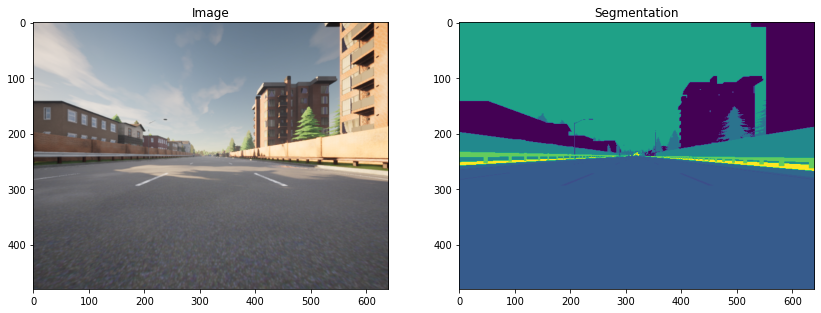

In [ ]:
# Check out some of unmasked and masked images from the dataset
N = 100
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
# mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
# Split dataset into Unmasked and Masked Images
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/u net/data/CameraMask/000028.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/drive/MyDrive/u net/data/CameraRGB/000026.png', shape=(), dtype=string)
tf.Tensor(b'/content/drive/MyDrive/u net/data/CameraMask/000026.png', shape=(), dtype=string)


**Preprocess Data**

Normally, we normalize our image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for us, so there's no need to further divide them by `255`.

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

**U-Net**

U-Net named for its U-shape, was originally created in 2015 for tumor detection but in the years since has become a very popular choice for other semantic segmentation tasks. 

U-Net builds on a previous architecture called the Fully Convolutional Network or FCN which replaces the dense layers found in a typical CNN with a transposed convolution layer that upsamples the feature map back to the size of the original input image while preserving the spatial information. This is necessary because the dense layers destroy spatial information (the "where" of the image), which is an essential part of image segmentation tasks. An added bonus of using transpose convolutions is that the input size no longer needs to be fixed as it does when dense layers are used. 

Unfortunately, the final feature layer of the FCN suffers from information loss due to downsampling too much. It then becomes difficult to upsample after so much information has been lost causing an output that looks rough. 

U-Net improves on the FCN, using a somewhat similar design but differing in some important ways.  Instead of one transposed convolution at the end of the network it uses a matching number of convolutions for downsampling the input image to a feature map and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss as well as model overfitting. 

### **Model Details**



**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture with convolutional layers, their activations and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 unpadded convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step the number of feature channels is doubled.

**Crop function**: This step crops the image from the contracting path and concatenates it to the current image on the expanding path to create a skip connection. 

**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path and two 3 x 3 convolutions, each followed by a ReLU. we need to perform cropping to handle the loss of border pixels in every convolution.

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used so when we use 1x1 convolutions, we can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, we can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

**Encoder (Downsampling Block)** 



The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout** and **MaxPooling2D** to some conv_blocks as we will verify in the following sections; specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  


### **conv_block**

Implementing `conv_block(...)`. Here are the instructions for each step in the `conv_block`, or contracting block: 

* Adding 2 **Conv2D** layers with `n_filters` filters with `kernel_size` set to 3, `kernel_initializer` set to ['he_normal'](https://www.tensorflow.org/api_docs/python/tf/keras/initializers/HeNormal), `padding` set to 'same' and 'relu' activation.
* if `dropout_prob` > 0, then adding a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then adding a MaxPooling2D layer with 2x2 pool size

In [ ]:
# conv block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
        
        # Convolutional downsampling block
    
        # Arguments:
        # inputs -> Input tensor
        # n_filters -> Number of filters for the convolutional layers
        # dropout_prob -> Dropout probability
        # max_pooling -> Use MaxPooling2D to reduce the spatial dimensions of the output volume
        
        # Returns: 
        # next_layer, skip_connection ->  Next layer and skip connection outputs
    

    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,         # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    
    # if dropout_prob > 0 add a dropout layer with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    
    
    return next_layer, skip_connection

**Decoder (Upsampling Block)**

The decoder or upsampling block, upsamples the features back to the original image size. At each upsampling level we'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.



There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here we'll encounter the `Conv2DTranspose` layer which performs the inverse of the `Conv2D` layer. Visit for more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)


### **upsampling_block**

Implementing `upsampling_block(...)`.

For the function `upsampling_block`: 
* Takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the previous skip layer)
* The number of filters here is the same as in the downsampling block we completed previously
* Our `Conv2DTranspose` layer will take `n_filters` with shape (3,3) and a stride of (2,2), with padding set to `same`. It's applied to `expansive_input`, or the input tensor from the previous layer. 

This block is also where we'll concatenate the outputs from the encoder blocks creating skip connections. 

* Concatenating our Conv2DTranspose layer output to the contractive input with an `axis` of 3. In general, we can concatenate the tensors in the order that one prefer. Here using `[up, contractive_input]`

For the final component, setting the parameters for two Conv2D layers to the same values that we set for the two Conv2D layers in the encoder (ReLU activation, He normal initializer, `same` padding). 


In [ ]:
# upsampling block
def upsampling_block(expansive_input, contractive_input, n_filters=32):

        # Convolutional upsampling block
    
        # Arguments:
        # expansive_input -> Input tensor from previous layer
        # contractive_input -> Input tensor from previous skip layer
        # n_filters -> Number of filters for the convolutional layers
        
        # Returns: 
        # conv -> Tensor output


    up = Conv2DTranspose(
                n_filters,    # number of filters
                 3,           # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,            # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,           # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    
    return conv

### **unet_model**

For the function `unet_model`, specify the input shape, number of filters and number of classes (23 in this case).

For the first half of the model:

* Begin with a conv block that takes the inputs of the model and the number of filters
* Then, chain the first output element of each block to the input of the next convolutional block
* Next, double the number of filters at each step
* Beginning with `conv_block4` add `dropout_prob` of 0.3
* For the final conv_block set `dropout_prob` to 0.3 again and turn off max pooling  

For the second half:

* Use cblock5 as expansive_input and cblock4 as contractive_input with `n_filters` * 8. This is your bottleneck layer. 
* Chain the output of the previous block as expansive_input and the corresponding contractive block output.
* Note that we must use the second element of the contractive block before the max pooling layer. 
* At each step use half the number of filters of the previous block
* `conv9` is a Conv2D layer with ReLU activation, He normal initializer, `same` padding
* Finally, `conv10` is a Conv2D that takes the number of classes as the filter, a kernel size of 1 and "same" padding. The output of `conv10` is the output of your model. 

In [ ]:
# unet model
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
        # Arguments:
        # input_size -> Input shape 
        # n_filters -> Number of filters for the convolutional layers
        # n_classes -> Number of output classes
  
        # Returns: 
        # model -> tf.keras.Model

    inputs = Input(input_size)

    # Contracting Path (encoding)
    
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, 0.3) # Include a dropout_prob of 0.3 for this layer
    
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters * 16,0.3, max_pooling=False) 

    
    # Expanding Path (decoding)
    
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that one must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

 
    return model

**Set Model Dimensions**

In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

**Loss Function**

In semantic segmentation, we need as many masks as we have object classes. In the dataset we're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, we'll use sparse categorical crossentropy as our loss function to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when we're dealing with lots of classes.

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

**Dataset Handling**

Defining a function that allows us to display both an input image and its ground truth: the true mask. The true mask is what our trained model output is aiming to get as close to as possible. 

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


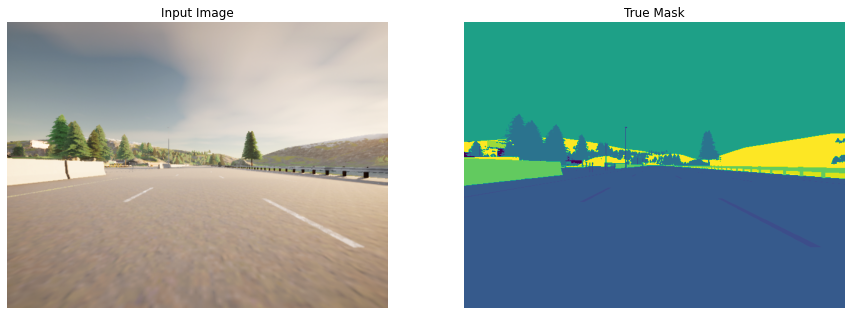

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


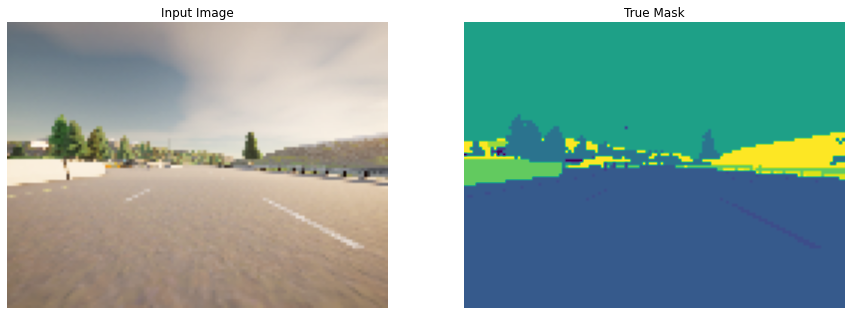

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

**Training Model**

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 459s 13s/step - loss: 2.0054 - accuracy: 0.3901
Epoch 2/40
34/34 [==============================] - 404s 12s/step - loss: 0.9338 - accuracy: 0.7549
Epoch 3/40
34/34 [==============================] - 405s 12s/step - loss: 0.6455 - accuracy: 0.8171
Epoch 4/40
34/34 [==============================] - 405s 12s/step - loss: 0.5395 - accuracy: 0.8380
Epoch 5/40
34/34 [==============================] - 404s 12s/step - loss: 0.4404 - accuracy: 0.8669
Epoch 6/40
34/34 [==============================] - 413s 12s/step - loss: 0.3821 - accuracy: 0.8850
Epoch 7/40
34/34 [==============================] - 452s 13s/step - loss: 0.3227 - accuracy: 0.9037
Epoch 8/40
34/34 [==============================] - 467s 14s/step - loss: 0.2905 - accuracy: 0.9150
Epoch 9/40
34/34 [==============================] - 450s 13s/step - loss: 0.256

**Create Predicted Masks** 

Defining a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image.

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

**Model Accuracy**

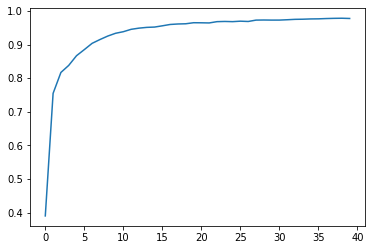

In [ ]:
plt.plot(model_history.history["accuracy"])

**Showing Predictions**

In [ ]:
def show_predictions(dataset=None, num=1):
    # Displays the first image of each of the num batches

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

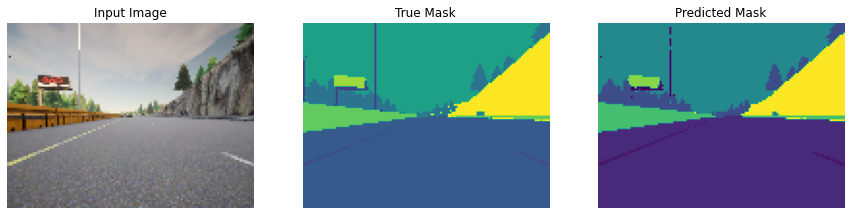

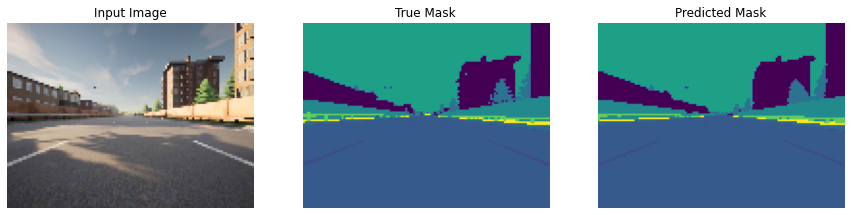

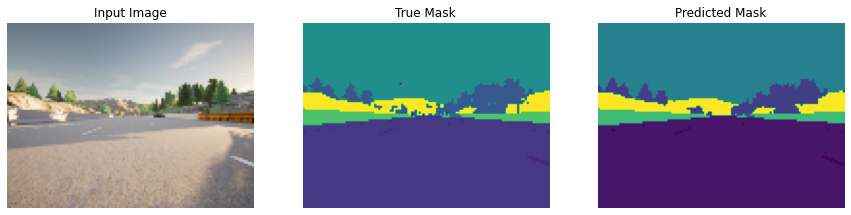

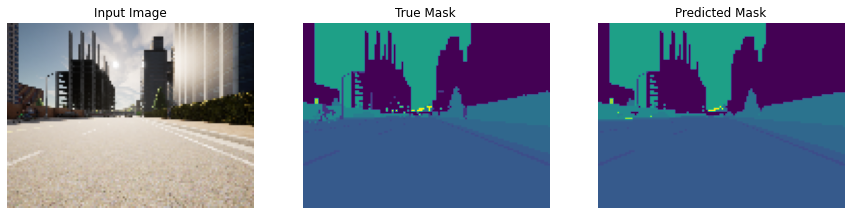

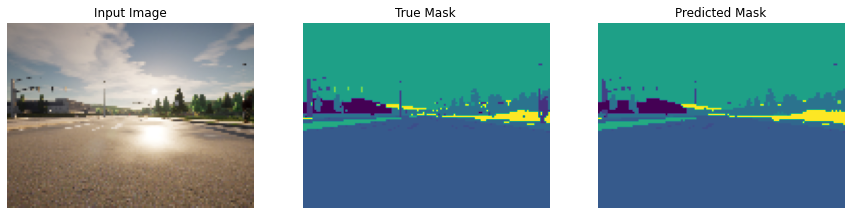

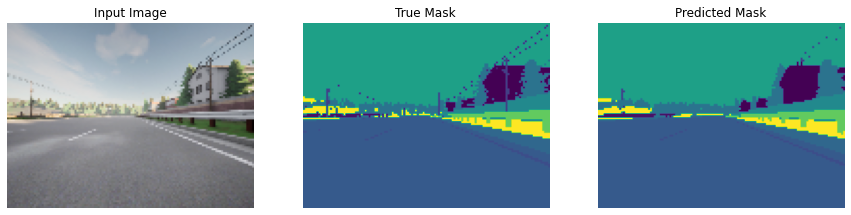

In [ ]:
show_predictions(train_dataset, 6)

To Remember :
* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net